In [428]:
# data
import pandas as pd
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from scipy import stats

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning
import tensorflow as tf
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb

# tqdm
from tqdm import tqdm_notebook as tqdm

tf.set_random_seed(777)  # reproducibility

# layers
from tensorflow.contrib.layers import fully_connected, batch_norm, dropout
from tensorflow.contrib.framework import arg_scope

# miscellaneous
from datetime import datetime
from time import time

In [395]:
train_df = pd.read_csv('./data/train.csv')
test_df = pd.read_csv('./data/test.csv')
result_df = pd.read_csv('./data/sampleSubmission.csv')

In [396]:
train_df.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541


In [397]:
test_df.head()

,Id,Dates,DayOfWeek,PdDistrict,Address,X,Y
0,0,2015-05-10 23:59:00,Sunday,BAYVIEW,2000 Block of THOMAS AV,-122.399588,37.735051
1,1,2015-05-10 23:51:00,Sunday,BAYVIEW,3RD ST / REVERE AV,-122.391523,37.732432
2,2,2015-05-10 23:50:00,Sunday,NORTHERN,2000 Block of GOUGH ST,-122.426002,37.792212
3,3,2015-05-10 23:45:00,Sunday,INGLESIDE,4700 Block of MISSION ST,-122.437394,37.721412
4,4,2015-05-10 23:45:00,Sunday,INGLESIDE,4700 Block of MISSION ST,-122.437394,37.721412


In [398]:
result_df.head()

,Id,ARSON,ASSAULT,BAD CHECKS,BRIBERY,BURGLARY,DISORDERLY CONDUCT,DRIVING UNDER THE INFLUENCE,DRUG/NARCOTIC,DRUNKENNESS,...,SEX OFFENSES NON FORCIBLE,STOLEN PROPERTY,SUICIDE,SUSPICIOUS OCC,TREA,TRESPASS,VANDALISM,VEHICLE THEFT,WARRANTS,WEAPON LAWS
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [399]:
train_df.describe()

,X,Y
count,878049.000000,878049.000000
mean,-122.422616,37.771020
std,0.030354,0.456893
min,-122.513642,37.707879
25%,-122.432952,37.752427
50%,-122.416420,37.775421
75%,-122.406959,37.784369
max,-120.500000,90.000000


In [400]:
train_df.describe(include=['O'])

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address
count,878049,878049,878049,878049,878049,878049,878049
unique,389257,39,879,7,10,17,23228
top,2011-01-01 00:01:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Friday,SOUTHERN,NONE,800 Block of BRYANT ST
freq,185,174900,60022,133734,157182,526790,26533


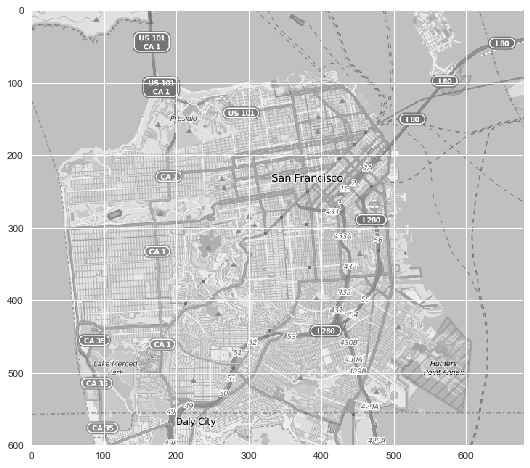

In [401]:
mapdata = np.loadtxt("./data/sf_map_copyright_openstreetmap_contributors.txt")
f, ax = plt.subplots(figsize=(12, 8))
plt.imshow(mapdata, cmap = plt.get_cmap('gray'))

In [402]:
train_labels = train_df[['Category', 'Descript', 'Resolution']]
train_df_concat = train_df.drop(['Category', 'Descript', 'Resolution'], axis=1)

train_labels

,Category,Descript,Resolution
0,WARRANTS,WARRANT ARREST,"ARREST, BOOKED"
1,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,"ARREST, BOOKED"
2,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,"ARREST, BOOKED"
3,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,NONE
4,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,NONE
5,LARCENY/THEFT,GRAND THEFT FROM UNLOCKED AUTO,NONE
6,VEHICLE THEFT,STOLEN AUTOMOBILE,NONE
7,VEHICLE THEFT,STOLEN AUTOMOBILE,NONE
8,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,NONE
9,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,NONE


In [403]:
set(train_df['Category'])
sorted(train_df['Category'].unique())

['ARSON',
 'ASSAULT',
 'BAD CHECKS',
 'BRIBERY',
 'BURGLARY',
 'DISORDERLY CONDUCT',
 'DRIVING UNDER THE INFLUENCE',
 'DRUG/NARCOTIC',
 'DRUNKENNESS',
 'EMBEZZLEMENT',
 'EXTORTION',
 'FAMILY OFFENSES',
 'FORGERY/COUNTERFEITING',
 'FRAUD',
 'GAMBLING',
 'KIDNAPPING',
 'LARCENY/THEFT',
 'LIQUOR LAWS',
 'LOITERING',
 'MISSING PERSON',
 'NON-CRIMINAL',
 'OTHER OFFENSES',
 'PORNOGRAPHY/OBSCENE MAT',
 'PROSTITUTION',
 'RECOVERED VEHICLE',
 'ROBBERY',
 'RUNAWAY',
 'SECONDARY CODES',
 'SEX OFFENSES FORCIBLE',
 'SEX OFFENSES NON FORCIBLE',
 'STOLEN PROPERTY',
 'SUICIDE',
 'SUSPICIOUS OCC',
 'TREA',
 'TRESPASS',
 'VANDALISM',
 'VEHICLE THEFT',
 'WARRANTS',
 'WEAPON LAWS']

In [404]:
test_id = test_df.pop('Id')
test_df

,Dates,DayOfWeek,PdDistrict,Address,X,Y
0,2015-05-10 23:59:00,Sunday,BAYVIEW,2000 Block of THOMAS AV,-122.399588,37.735051
1,2015-05-10 23:51:00,Sunday,BAYVIEW,3RD ST / REVERE AV,-122.391523,37.732432
2,2015-05-10 23:50:00,Sunday,NORTHERN,2000 Block of GOUGH ST,-122.426002,37.792212
3,2015-05-10 23:45:00,Sunday,INGLESIDE,4700 Block of MISSION ST,-122.437394,37.721412
4,2015-05-10 23:45:00,Sunday,INGLESIDE,4700 Block of MISSION ST,-122.437394,37.721412
5,2015-05-10 23:40:00,Sunday,TARAVAL,BROAD ST / CAPITOL AV,-122.459024,37.713172
6,2015-05-10 23:30:00,Sunday,INGLESIDE,100 Block of CHENERY ST,-122.425616,37.739351
7,2015-05-10 23:30:00,Sunday,INGLESIDE,200 Block of BANKS ST,-122.412652,37.739750
8,2015-05-10 23:10:00,Sunday,MISSION,2900 Block of 16TH ST,-122.418700,37.765165
9,2015-05-10 23:10:00,Sunday,CENTRAL,TAYLOR ST / GREEN ST,-122.413935,37.798886


In [405]:
features = pd.concat([train_df_concat, test_df], keys = ['train_df', 'test_df'])
features

Dates  DayOfWeek  PdDistrict  \
train_df 0       2015-05-13 23:53:00  Wednesday    NORTHERN   
         1       2015-05-13 23:53:00  Wednesday    NORTHERN   
         2       2015-05-13 23:33:00  Wednesday    NORTHERN   
         3       2015-05-13 23:30:00  Wednesday    NORTHERN   
         4       2015-05-13 23:30:00  Wednesday        PARK   
         5       2015-05-13 23:30:00  Wednesday   INGLESIDE   
         6       2015-05-13 23:30:00  Wednesday   INGLESIDE   
         7       2015-05-13 23:30:00  Wednesday     BAYVIEW   
         8       2015-05-13 23:00:00  Wednesday    RICHMOND   
         9       2015-05-13 23:00:00  Wednesday     CENTRAL   
         10      2015-05-13 22:58:00  Wednesday     CENTRAL   
         11      2015-05-13 22:30:00  Wednesday     TARAVAL   
         12      2015-05-13 22:30:00  Wednesday  TENDERLOIN   
         13      2015-05-13 22:06:00  Wednesday    NORTHERN   
         14      2015-05-13 22:00:00  Wednesday     BAYVIEW   
         15      2015-05-13 22:00:00  Wednesday     BAYVIEW   
         16      2015-05-13 22:00:00  Wednesday  TENDERLOIN   
         17      2015-05-13 21:55:00  Wednesday   INGLESIDE   
         18      2015-05-13 21:40:00  Wednesday     BAYVIEW   
         19      2015-05-13 21:30:00  Wednesday  TENDERLOIN   
         20      2015-05-13 21:30:00  Wednesday   INGLESIDE   
         21      2015-05-13 21:17:00  Wednesday   INGLESIDE   
         22      2015-05-13 21:11:00  Wednesday  TENDERLOIN   
         23      2015-05-13 21:11:00  Wednesday  TENDERLOIN   
         24      2015-05-13 21:10:00  Wednesday    NORTHERN   
         25      2015-05-13 21:00:00  Wednesday  TENDERLOIN   
         26      2015-05-13 21:00:00  Wednesday    NORTHERN   
         27      2015-05-13 21:00:00  Wednesday   INGLESIDE   
         28      2015-05-13 21:00:00  Wednesday     TARAVAL   
         29      2015-05-13 20:56:00  Wednesday     TARAVAL   
...                              ...        ...         ...   
test_df  884232  2003-01-01 00:01:00  Wednesday     MISSION   
         884233  2003-01-01 00:01:00  Wednesday    SOUTHERN   
         884234  2003-01-01 00:01:00  Wednesday    RICHMOND   
         884235  2003-01-01 00:01:00  Wednesday   INGLESIDE   
         884236  2003-01-01 00:01:00  Wednesday     MISSION   
         884237  2003-01-01 00:01:00  Wednesday     CENTRAL   
         884238  2003-01-01 00:01:00  Wednesday     TARAVAL   
         884239  2003-01-01 00:01:00  Wednesday     MISSION   
         884240  2003-01-01 00:01:00  Wednesday    RICHMOND   
         884241  2003-01-01 00:01:00  Wednesday     BAYVIEW   
         884242  2003-01-01 00:01:00  Wednesday     MISSION   
         884243  2003-01-01 00:01:00  Wednesday     MISSION   
         884244  2003-01-01 00:01:00  Wednesday     BAYVIEW   
         884245  2003-01-01 00:01:00  Wednesday  TENDERLOIN   
         884246  2003-01-01 00:01:00  Wednesday     BAYVIEW   
         884247  2003-01-01 00:01:00  Wednesday     MISSION   
         884248  2003-01-01 00:01:00  Wednesday     CENTRAL   
         884249  2003-01-01 00:01:00  Wednesday     CENTRAL   
         884250  2003-01-01 00:01:00  Wednesday    SOUTHERN   
         884251  2003-01-01 00:01:00  Wednesday     MISSION   
         884252  2003-01-01 00:01:00  Wednesday   INGLESIDE   
         884253  2003-01-01 00:01:00  Wednesday     CENTRAL   
         884254  2003-01-01 00:01:00  Wednesday     CENTRAL   
         884255  2003-01-01 00:01:00  Wednesday   INGLESIDE   
         884256  2003-01-01 00:01:00  Wednesday     MISSION   
         884257  2003-01-01 00:01:00  Wednesday     MISSION   
         884258  2003-01-01 00:01:00  Wednesday    NORTHERN   
         884259  2003-01-01 00:01:00  Wednesday   INGLESIDE   
         884260  2003-01-01 00:01:00  Wednesday     BAYVIEW   
         884261  2003-01-01 00:01:00  Wednesday     TARAVAL   

                                       Address           X          Y  
train_df 0                  OAK ST / LAGUNA ST -122.

In [406]:
dateTime = pd.to_datetime(features['Dates'], format='%Y-%m-%d %H:%M:%S')
YMD = pd.concat([dateTime.dt.year, dateTime.dt.month, dateTime.dt.day], axis=1, keys=['Year', 'Month', 'Day'])
HMS = pd.concat([dateTime.dt.hour, dateTime.dt.minute, dateTime.dt.second], axis=1, keys=['hour', 'minute', 'second'])

In [407]:
features = pd.concat([features, YMD, HMS], axis=1)
features

Dates  DayOfWeek  PdDistrict  \
train_df 0       2015-05-13 23:53:00  Wednesday    NORTHERN   
         1       2015-05-13 23:53:00  Wednesday    NORTHERN   
         2       2015-05-13 23:33:00  Wednesday    NORTHERN   
         3       2015-05-13 23:30:00  Wednesday    NORTHERN   
         4       2015-05-13 23:30:00  Wednesday        PARK   
         5       2015-05-13 23:30:00  Wednesday   INGLESIDE   
         6       2015-05-13 23:30:00  Wednesday   INGLESIDE   
         7       2015-05-13 23:30:00  Wednesday     BAYVIEW   
         8       2015-05-13 23:00:00  Wednesday    RICHMOND   
         9       2015-05-13 23:00:00  Wednesday     CENTRAL   
         10      2015-05-13 22:58:00  Wednesday     CENTRAL   
         11      2015-05-13 22:30:00  Wednesday     TARAVAL   
         12      2015-05-13 22:30:00  Wednesday  TENDERLOIN   
         13      2015-05-13 22:06:00  Wednesday    NORTHERN   
         14      2015-05-13 22:00:00  Wednesday     BAYVIEW   
         15      2015-05-13 22:00:00  Wednesday     BAYVIEW   
         16      2015-05-13 22:00:00  Wednesday  TENDERLOIN   
         17      2015-05-13 21:55:00  Wednesday   INGLESIDE   
         18      2015-05-13 21:40:00  Wednesday     BAYVIEW   
         19      2015-05-13 21:30:00  Wednesday  TENDERLOIN   
         20      2015-05-13 21:30:00  Wednesday   INGLESIDE   
         21      2015-05-13 21:17:00  Wednesday   INGLESIDE   
         22      2015-05-13 21:11:00  Wednesday  TENDERLOIN   
         23      2015-05-13 21:11:00  Wednesday  TENDERLOIN   
         24      2015-05-13 21:10:00  Wednesday    NORTHERN   
         25      2015-05-13 21:00:00  Wednesday  TENDERLOIN   
         26      2015-05-13 21:00:00  Wednesday    NORTHERN   
         27      2015-05-13 21:00:00  Wednesday   INGLESIDE   
         28      2015-05-13 21:00:00  Wednesday     TARAVAL   
         29      2015-05-13 20:56:00  Wednesday     TARAVAL   
...                              ...        ...         ...   
test_df  884232  2003-01-01 00:01:00  Wednesday     MISSION   
         884233  2003-01-01 00:01:00  Wednesday    SOUTHERN   
         884234  2003-01-01 00:01:00  Wednesday    RICHMOND   
         884235  2003-01-01 00:01:00  Wednesday   INGLESIDE   
         884236  2003-01-01 00:01:00  Wednesday     MISSION   
         884237  2003-01-01 00:01:00  Wednesday     CENTRAL   
         884238  2003-01-01 00:01:00  Wednesday     TARAVAL   
         884239  2003-01-01 00:01:00  Wednesday     MISSION   
         884240  2003-01-01 00:01:00  Wednesday    RICHMOND   
         884241  2003-01-01 00:01:00  Wednesday     BAYVIEW   
         884242  2003-01-01 00:01:00  Wednesday     MISSION   
         884243  2003-01-01 00:01:00  Wednesday     MISSION   
         884244  2003-01-01 00:01:00  Wednesday     BAYVIEW   
         884245  2003-01-01 00:01:00  Wednesday  TENDERLOIN   
         884246  2003-01-01 00:01:00  Wednesday     BAYVIEW   
         884247  2003-01-01 00:01:00  Wednesday     MISSION   
         884248  2003-01-01 00:01:00  Wednesday     CENTRAL   
         884249  2003-01-01 00:01:00  Wednesday     CENTRAL   
         884250  2003-01-01 00:01:00  Wednesday    SOUTHERN   
         884251  2003-01-01 00:01:00  Wednesday     MISSION   
         884252  2003-01-01 00:01:00  Wednesday   INGLESIDE   
         884253  2003-01-01 00:01:00  Wednesday     CENTRAL   
         884254  2003-01-01 00:01:00  Wednesday     CENTRAL   
         884255  2003-01-01 00:01:00  Wednesday   INGLESIDE   
         884256  2003-01-01 00:01:00  Wednesday     MISSION   
         884257  2003-01-01 00:01:00  Wednesday     MISSION   
         884258  2003-01-01 00:01:00  Wednesday    NORTHERN   
         884259  2003-01-01 00:01:00  Wednesday   INGLESIDE   
         884260  2003-01-01 00:01:00  Wednesday     BAYVIEW   
         884261  2003-01-01 00:01:00  Wednesday     TARAVAL   

                                       Address           X          Y  Year  \
train_df 0                  OAK ST / LAGUNA S

In [408]:
features = features.drop(['Dates'], axis=1)

In [409]:
features['Address'].value_counts()

800 Block of BRYANT ST                   53517
800 Block of MARKET ST                   13464
2000 Block of MISSION ST                 10052
1000 Block of POTRERO AV                  8210
0 Block of TURK ST                        6444
900 Block of MARKET ST                    6256
0 Block of 6TH ST                         5682
300 Block of ELLIS ST                     5488
16TH ST / MISSION ST                      5156
400 Block of ELLIS ST                     5026
1000 Block of MARKET ST                   4924
1100 Block of MARKET ST                   4563
100 Block of OFARRELL ST                  4464
2000 Block of MARKET ST                   4433
700 Block of MARKET ST                    4062
3200 Block of 20TH AV                     4036
100 Block of 6TH ST                       3858
500 Block of JOHNFKENNEDY DR              3728
0 Block of UNITEDNATIONS PZ               3650
0 Block of PHELAN AV                      3509
200 Block of TURK ST                      3477
TURK ST / TAY

In [410]:
features.describe(include=['O'])

,DayOfWeek,PdDistrict,Address
count,1762311,1762311,1762311
unique,7,10,24777
top,Friday,SOUTHERN,800 Block of BRYANT ST
freq,268437,314638,53517


In [411]:
features.describe()

,X,Y,Year,Month,Day,hour,minute,second
count,1.762311e+06,1.762311e+06,1.762311e+06,1.762311e+06,1.762311e+06,1.762311e+06,1.762311e+06,1762311.0
mean,-1.224227e+02,3.777125e+01,2.008708e+03,6.375071e+00,1.561060e+01,1.340431e+01,2.015405e+01,0.0
std,3.067205e-02,4.711145e-01,3.634536e+00,3.448681e+00,8.829256e+00,6.554258e+00,1.860271e+01,0.0
min,-1.225136e+02,3.770788e+01,2.003000e+03,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.0
25%,-1.224330e+02,3.775239e+01,2.006000e+03,3.000000e+00,8.000000e+00,9.000000e+00,0.000000e+00,0.0
50%,-1.224165e+02,3.777542e+01,2.009000e+03,6.000000e+00,1.600000e+01,1.400000e+01,1.900000e+01,0.0
75%,-1.224070e+02,3.778436e+01,2.012000e+03,9.000000e+00,2.300000e+01,1.900000e+01,3.300000e+01,0.0
max,-1.205000e+02,9.000000e+01,2.015000e+03,1.200000e+01,3.100000e+01,2.300000e+01,5.900000e+01,0.0


In [412]:
features = features.drop(['second', 'Address'], axis=1)
features.head()

DayOfWeek PdDistrict           X          Y  Year  Month  Day  \
train_df 0  Wednesday   NORTHERN -122.425892  37.774599  2015      5   13   
         1  Wednesday   NORTHERN -122.425892  37.774599  2015      5   13   
         2  Wednesday   NORTHERN -122.424363  37.800414  2015      5   13   
         3  Wednesday   NORTHERN -122.426995  37.800873  2015      5   13   
         4  Wednesday       PARK -122.438738  37.771541  2015      5   13   

            hour  minute  
train_df 0    23      53  
         1    23      53  
         2    23      33  
         3    23      30  
         4    23      30

In [413]:
features['Y'] = features['Y'].replace([90], features['Y'].mode()[0])

features['Y'].describe(include=['O'])

count    1.762311e+06
mean     3.776701e+01
std      2.417117e-02
min      3.770788e+01
25%      3.775239e+01
50%      3.777542e+01
75%      3.778435e+01
max      3.782062e+01
Name: Y, dtype: float64

In [414]:
xyScaler = StandardScaler()
xyScaler.fit(features[['X', 'Y']])
features[['X', 'Y']] = xyScaler.transform(features[['X', 'Y']])

features[['X', 'Y']]

X         Y
train_df 0      -0.105527  0.313905
         1      -0.105527  0.313905
         2      -0.055688  1.381943
         3      -0.141509  1.400904
         4      -0.524343  0.187415
         5       0.632582 -2.216709
         6      -0.021910 -1.732358
         7       1.675162 -1.631989
         8      -2.788829  0.396759
         9       0.116304  1.687565
         10      0.116304  1.687565
         11     -2.129891 -1.214029
         12      0.333877  0.661642
         13     -0.334495  0.717475
         14      0.812158 -1.533912
         15      1.270325 -0.985559
         16      0.327907  0.700044
         17      0.031737 -1.000735
         18      1.181991 -1.159549
         19      0.339240  0.643129
         20     -0.871613 -1.007082
         21      0.077687 -0.814173
         22      0.339240  0.643129
         23      0.339240  0.643129
         24     -0.436692  1.358233
         25      0.395986  0.787388
         26     -0.272646  0.843026
         27     -0.032648 -1.425444
         28     -1.731823 -0.913985
         29     -2.514738 -0.765107
...                   ...       ...
test_df  884232  0.430967 -0.489575
         884233  0.977572  0.636601
         884234 -2.285687  0.251780
         884235 -0.929479 -0.887303
         884236 -0.045055 -0.176233
         884237  0.251743  1.003014
         884238 -1.803653 -1.658030
         884239  0.445732 -0.621571
         884240 -0.690541  1.039479
         884241  0.437979 -1.473587
         884242  0.259899 -0.369601
         884243 -0.433455 -0.356112
         884244  0.486879 -1.756799
         884245  0.290209  0.691688
         884246  1.290094 -1.458713
         884247  0.441117 -0.386135
         884248  0.573469  1.282616
         884249  0.443201  1.227393
         884250  0.627613  0.347917
         884251  0.484066 -0.161834
         884252 -0.743710 -1.470795
         884253  0.389062  0.830970
         884254  0.143965  0.989695
         884255  0.275989 -0.814698
         884256 -0.104626 -0.031340
         884257  0.445732 -0.621571
         884258 -0.087616  1.062018
         884259 -0.742150 -2.272805
         884260  1.149608 -1.139038
         884261 -2.186323 -1.367802

[1762311 rows x 2 columns]

In [415]:
train_df

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541
5,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM UNLOCKED AUTO,Wednesday,INGLESIDE,NONE,0 Block of TEDDY AV,-122.403252,37.713431
6,2015-05-13 23:30:00,VEHICLE THEFT,STOLEN AUTOMOBILE,Wednesday,INGLESIDE,NONE,AVALON AV / PERU AV,-122.423327,37.725138
7,2015-05-13 23:30:00,VEHICLE THEFT,STOLEN AUTOMOBILE,Wednesday,BAYVIEW,NONE,KIRKWOOD AV / DONAHUE ST,-122.371274,37.727564
8,2015-05-13 23:00:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,RICHMOND,NONE,600 Block of 47TH AV,-122.508194,37.776601
9,2015-05-13 23:00:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,CENTRAL,NONE,JEFFERSON ST / LEAVENWORTH ST,-122.419088,37.807802


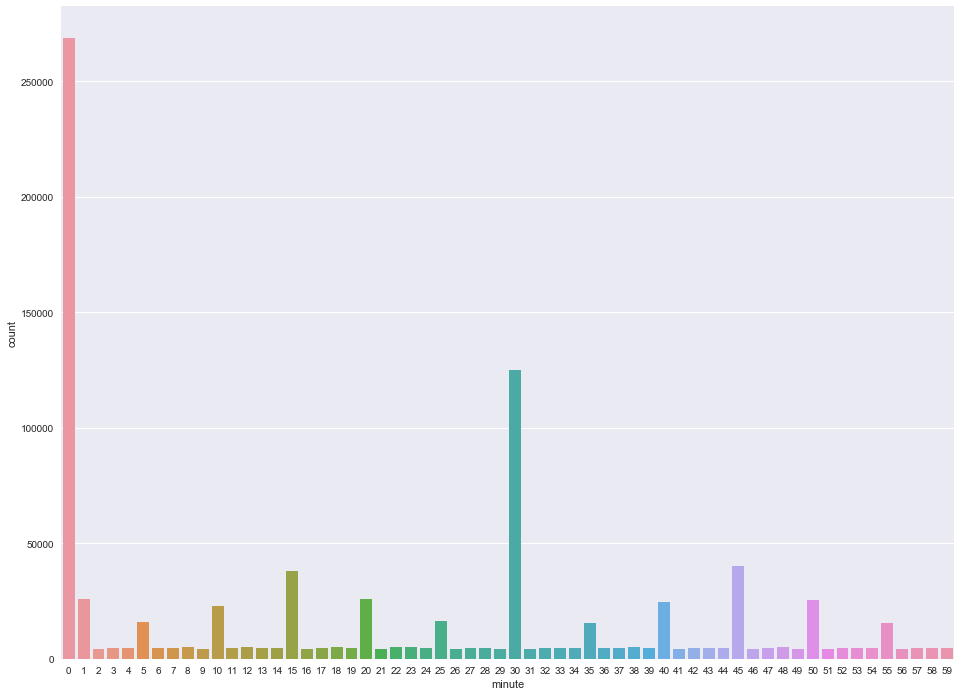

In [416]:
f, ax = plt.subplots(1, 1, figsize=(16,12))
data = pd.concat([features.loc['train_df']['minute'], train_df['Category']], axis=1)
sns.countplot(x="minute", data=data)

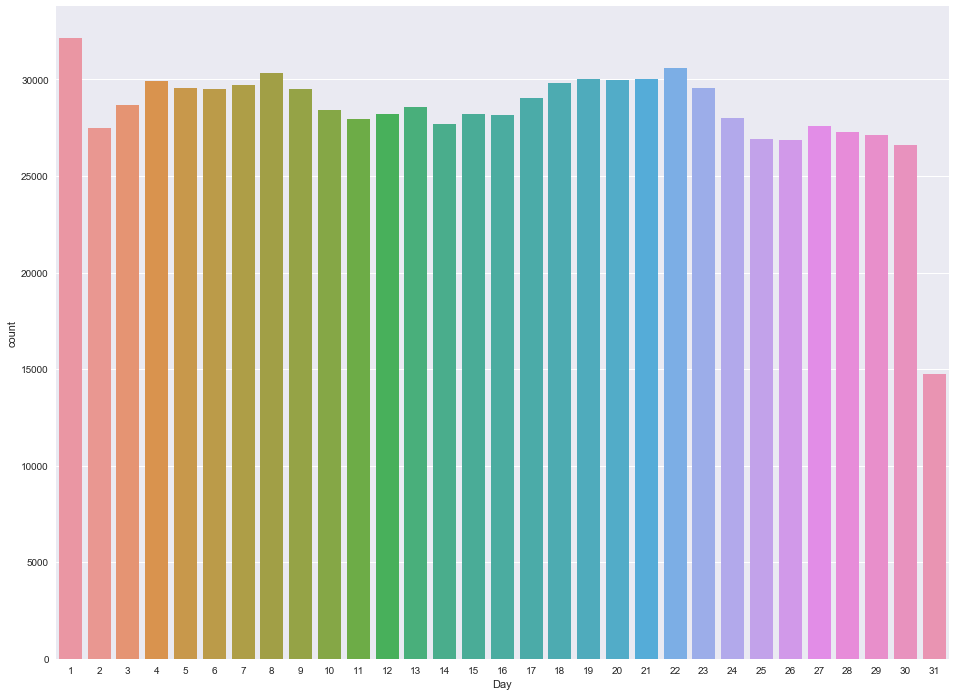

In [417]:
f, ax = plt.subplots(1, 1, figsize=(16,12))
data = pd.concat([features.loc['train_df']['Day'], train_df['Category']], axis=1)
sns.countplot(x="Day", data=data)

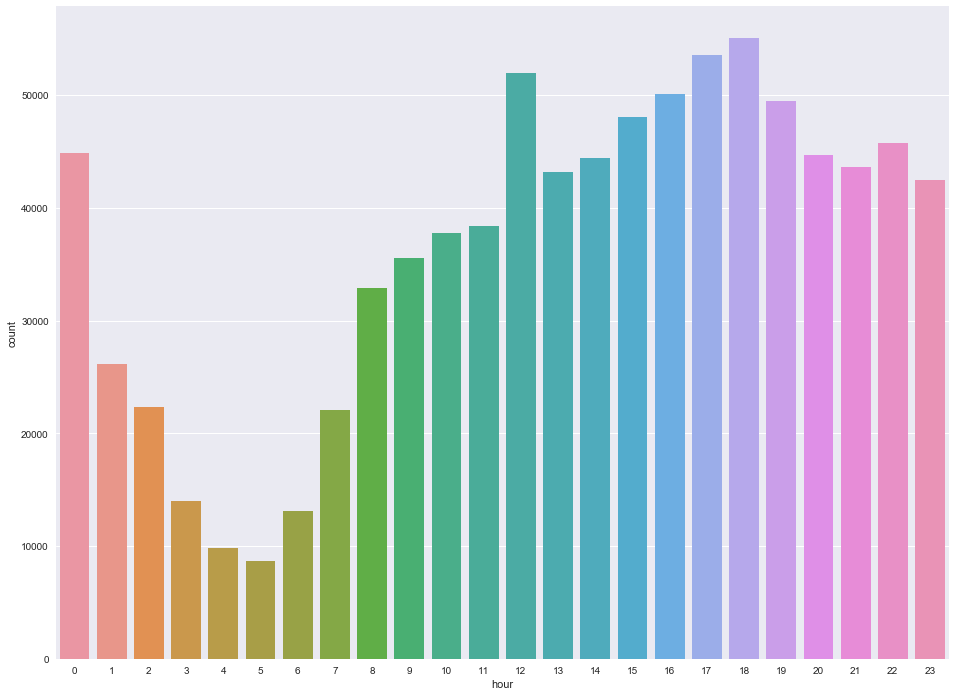

In [418]:
f, ax = plt.subplots(1, 1, figsize=(16,12))
data = pd.concat([features.loc['train_df']['hour'], train_df['Category']], axis=1)
sns.countplot(x="hour", data=data)

In [419]:
features.loc[(features['Day'] >= 1) & (features['Day'] < 8), 'Day'] = 1
features.loc[(features['Day'] >= 8) & (features['Day'] < 15), 'Day'] = 2
features.loc[(features['Day'] >= 15) & (features['Day'] < 22), 'Day'] = 3
features.loc[(features['Day'] >= 22) & (features['Day'] < 29), 'Day'] = 4
features.loc[features['Day'] >= 29, 'Day'] = 5

features.loc[(features['minute'] >= 0) & (features['minute'] < 5), 'minute'] = 0
features.loc[(features['minute'] >= 5) & (features['minute'] < 10), 'minute'] = 1
features.loc[(features['minute'] >= 10) & (features['minute'] < 15), 'minute'] = 2
features.loc[(features['minute'] >= 15) & (features['minute'] < 20), 'minute'] = 3
features.loc[(features['minute'] >= 20) & (features['minute'] < 25), 'minute'] = 4
features.loc[(features['minute'] >= 25) & (features['minute'] < 30), 'minute'] = 5
features.loc[(features['minute'] >= 30) & (features['minute'] < 35), 'minute'] = 6
features.loc[(features['minute'] >= 35) & (features['minute'] < 40), 'minute'] = 7
features.loc[(features['minute'] >= 40) & (features['minute'] < 45), 'minute'] = 8
features.loc[(features['minute'] >= 45) & (features['minute'] < 50), 'minute'] = 9
features.loc[(features['minute'] >= 50) & (features['minute'] < 55), 'minute'] = 10
features.loc[(features['minute'] >= 55) & (features['minute'] < 60), 'minute'] = 11

features.head()

DayOfWeek PdDistrict         X         Y  Year  Month  Day  hour  \
train_df 0  Wednesday   NORTHERN -0.105527  0.313905  2015      5    2    23   
         1  Wednesday   NORTHERN -0.105527  0.313905  2015      5    2    23   
         2  Wednesday   NORTHERN -0.055688  1.381943  2015      5    2    23   
         3  Wednesday   NORTHERN -0.141509  1.400904  2015      5    2    23   
         4  Wednesday       PARK -0.524343  0.187415  2015      5    2    23   

            minute  
train_df 0      10  
         1      10  
         2       6  
         3       6  
         4       6

In [420]:
features['Year'] = features['Year'].astype(str)
features['Month'] = features['Month'].astype(str)
features['Day'] = features['Day'].astype(str)
features['hour'] = features['hour'].astype(str)
features['minute'] = features['minute'].astype(str)

In [421]:
for col in features.dtypes[features.dtypes == 'object'].index:
    for_dummy = features.pop(col)
    features = pd.concat([features, pd.get_dummies(for_dummy, prefix=col)], axis=1)

In [422]:
print(features.columns)
len(features.columns)

Index(['X', 'Y', 'DayOfWeek_Friday', 'DayOfWeek_Monday', 'DayOfWeek_Saturday',
       'DayOfWeek_Sunday', 'DayOfWeek_Thursday', 'DayOfWeek_Tuesday',
       'DayOfWeek_Wednesday', 'PdDistrict_BAYVIEW', 'PdDistrict_CENTRAL',
       'PdDistrict_INGLESIDE', 'PdDistrict_MISSION', 'PdDistrict_NORTHERN',
       'PdDistrict_PARK', 'PdDistrict_RICHMOND', 'PdDistrict_SOUTHERN',
       'PdDistrict_TARAVAL', 'PdDistrict_TENDERLOIN', 'Year_2003', 'Year_2004',
       'Year_2005', 'Year_2006', 'Year_2007', 'Year_2008', 'Year_2009',
       'Year_2010', 'Year_2011', 'Year_2012', 'Year_2013', 'Year_2014',
       'Year_2015', 'Month_1', 'Month_10', 'Month_11', 'Month_12', 'Month_2',
       'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8',
       'Month_9', 'Day_1', 'Day_2', 'Day_3', 'Day_4', 'Day_5', 'hour_0',
       'hour_1', 'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14',
       'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_2',
       'hour_20', 'hour_21', 'hour_22

85

In [423]:
features.head()

X         Y  DayOfWeek_Friday  DayOfWeek_Monday  \
train_df 0 -0.105527  0.313905                 0                 0   
         1 -0.105527  0.313905                 0                 0   
         2 -0.055688  1.381943                 0                 0   
         3 -0.141509  1.400904                 0                 0   
         4 -0.524343  0.187415                 0                 0   

            DayOfWeek_Saturday  DayOfWeek_Sunday  DayOfWeek_Thursday  \
train_df 0                   0                 0                   0   
         1                   0                 0                   0   
         2                   0                 0                   0   
         3                   0                 0                   0   
         4                   0                 0                   0   

            DayOfWeek_Tuesday  DayOfWeek_Wednesday  PdDistrict_BAYVIEW  \
train_df 0                  0                    1                   0   
         1                  0                    1                   0   
         2                  0                    1                   0   
         3                  0                    1                   0   
         4                  0                    1                   0   

              ...     minute_10  minute_11  minute_2  minute_3  minute_4  \
train_df 0    ...             1          0         0         0         0   
         1    ...             1          0         0         0         0   
         2    ...             0          0         0         0         0   
         3    ...             0          0         0         0         0   
         4    ...             0          0         0         0         0   

            minute_5  minute_6  minute_7  minute_8  minute_9  
train_df 0         0         0         0         0         0  
         1         0         0         0         0         0  
         2         0         1         0         0         0  
         3         0         1         0         0         0  
         4         0         1         0         0         0  

[5 rows x 85 columns]

In [424]:
train_columns = train_labels['Category'].unique()
train_columns.sort()
test = train_labels['Category'].copy()
y_data = pd.get_dummies(columns = train_columns, data=test)
y_data

,ARSON,ASSAULT,BAD CHECKS,BRIBERY,BURGLARY,DISORDERLY CONDUCT,DRIVING UNDER THE INFLUENCE,DRUG/NARCOTIC,DRUNKENNESS,EMBEZZLEMENT,...,SEX OFFENSES NON FORCIBLE,STOLEN PROPERTY,SUICIDE,SUSPICIOUS OCC,TREA,TRESPASS,VANDALISM,VEHICLE THEFT,WARRANTS,WEAPON LAWS
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [425]:
x_data = features.loc['train_df']

In [426]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, random_state=42)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((658536, 85), (219513, 85), (658536, 39), (219513, 39))

In [ ]:
forest = RandomForestClassifier(n_estimators=30, random_state=0, verbose=True)
forest.fit(x_train, y_train)

print("train set accuracy: {:.3f}".format(forest.score(x_train, y_train)))
print("test set accuracy: {:.3f}".format(forest.score(x_test, y_test)))

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  6.5min finished


In [430]:
gbrt = GradientBoostingClassifier(random_state=0, verbose=True)
gbrt.fit(x_train, y_train)

print("train set accuracy: {:.3f}".format(gbrt.score(x_train, y_train)))
print("test set accuracy: {:.3f}".format(gbrt.score(x_test, y_test)))

ValueError: bad input shape (658536, 39)